In [9]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.anyspell import *
from jetstream_hugo.data import *
import colormaps
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
exp = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/6"))
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
props_as_df = get_nao(props_as_df)
jet_pos_da = exp.jet_position_as_da()
# props_as_df = get_double_jet_index(props_as_df, jet_pos_da)

In [11]:
metric = "euclidean"
nx = 6
ny = 4
exp_s = Experiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/4"))

ds_center_path = exp_s.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds = ds.sel(time=ds.time.dt.season=="JJA")
net, centers, labels = exp_s.som_cluster(
    nx,
    ny,
    activation_distance=metric,
    return_type=RAW_REALSPACE,
    force=False,
    sigma=2,
    train_kwargs=dict(num_epochs=20),
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
if not ds_center_path.is_file():
    ds_center = labels_to_centers(labels, ds)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s.da.time, "cluster": np.arange(net.n_nodes)})

In [83]:
compute_all_smoothed_anomalies("ERA5", "surf", "t", "6H", 'dayofyear', {'dayofyear': ('win', 15)}, None)

In [85]:
da_tp = open_da(
    "ERA5", "surf", "tp", "6H", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_T = open_da(
    "ERA5", "surf", "t", "6H", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
# da_sst = open_da(
#     "ERA5", "surf", "sst", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
# )
# da_mslp = open_da(
#     "ERA5", "surf", "mslp", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
# )
# da_apvs = open_da(
#     "ERA5", "thetalev", "apvs_int", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
# )
# da_cpvs = open_da(
#     "ERA5", "thetalev", "cpvs_int", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
# )
# da_z = open_da(
#     "ERA5", "plev", "z", "dailymean", "all", "JJA", None, None, None, None, 500, 'dayofyear', {'dayofyear': ('win', 15)}, None,
# )

In [86]:
time = labels.time.values
labels_ = labels.values
jump_indices = np.where(np.diff(labels) != 0)[0]
jumps = np.asarray(list(map(tuple, zip(labels_[jump_indices], labels_[jump_indices + 1]))), dtype="i1, i1")
jumps_magnitudes = net.neighborhoods.distances[labels_[jump_indices], labels_[jump_indices + 1]]
jumps_times = time[jump_indices]
unique_jumps, inverse, count = np.unique(jumps, return_inverse=True, return_counts=True)
high_count = count > np.quantile(count, 0.95)

In [110]:
da_ = da_T.sel(lon=slice(-80, 40), lat=slice(25, 80))
da_ = compute(da_, progress_flag=True)
to_plot = []
titles = []
for frequent_jump in tqdm(np.where(high_count)[0]):
    times_ = jumps_times[inverse == frequent_jump]
    jump_tuple = unique_jumps[frequent_jump].item()
    jump_magnitude = net.neighborhoods.distances[jump_tuple]
    jump_count = count[frequent_jump]
    to_plot.append(da_.sel(time=times_).mean("time"))
    titles.append(f"jump: {jump_tuple}, mag {jump_magnitude}, count: {jump_count}")
frequent_jumps = np.isin(inverse, np.where(high_count)[0])
to_plot.append(da_.sel(time=jumps_times[frequent_jumps]).mean("time"))
titles.append(f"count: {np.sum(frequent_jumps)}")

[########################################] | 100% Completed | 99.63 s


100%|██████████| 17/17 [00:00<00:00, 460.23it/s]


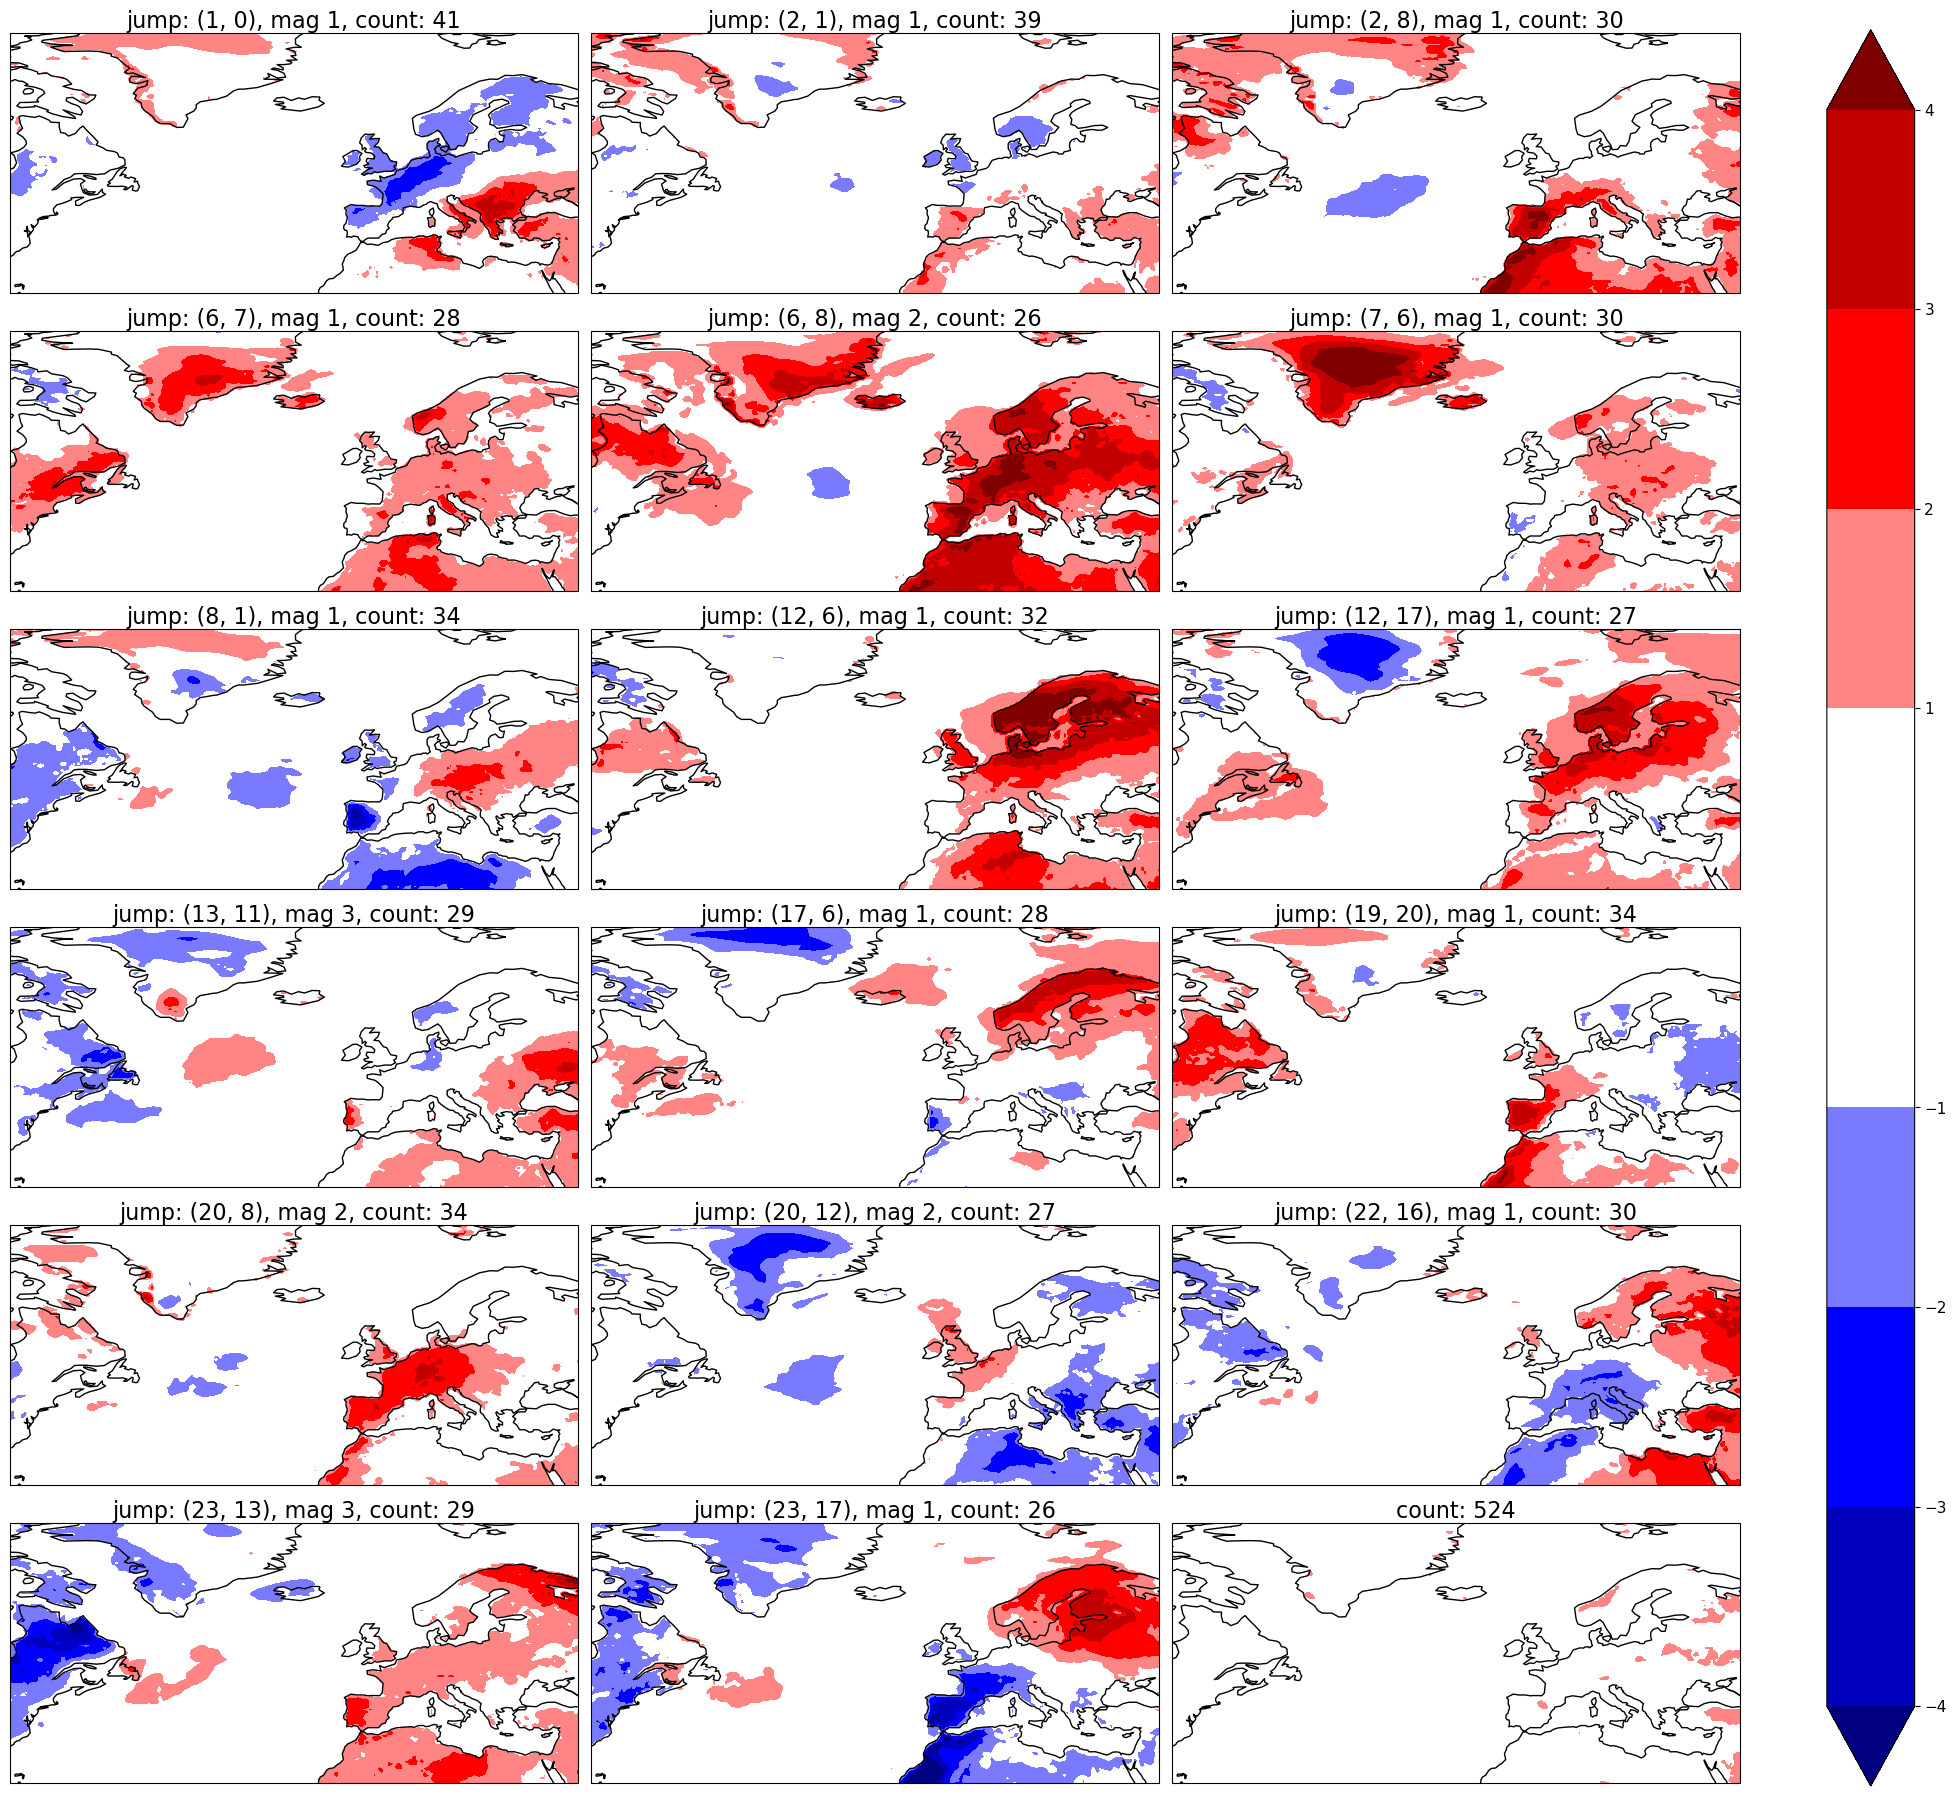

In [111]:
clu = Clusterplot(6, 3, region=get_region(da_))
_ = clu.add_contourf([a for a in to_plot], titles=titles, cmap=colormaps.BlWhRe, levels=7, transparify=0)

In [108]:
da_ = da_tp.sel(lon=slice(-80, 40), lat=slice(25, 80))
da_ = compute(da_, progress_flag=True)
to_plot = []
titles = []
for frequent_jump in tqdm(np.where(high_count)[0]):
    times_ = jumps_times[inverse == frequent_jump]
    jump_tuple = unique_jumps[frequent_jump].item()
    jump_magnitude = net.neighborhoods.distances[jump_tuple]
    jump_count = count[frequent_jump]
    to_plot.append(da_.sel(time=times_).mean("time"))
    titles.append(f"jump: {jump_tuple}, mag {jump_magnitude}, count: {jump_count}")
frequent_jumps = np.isin(inverse, np.where(high_count)[0])
to_plot.append(da_.sel(time=jumps_times[frequent_jumps]).mean("time"))
titles.append(f"count: {np.sum(frequent_jumps)}")

[########################################] | 100% Completed | 103.25 s


100%|██████████| 17/17 [00:00<00:00, 472.46it/s]


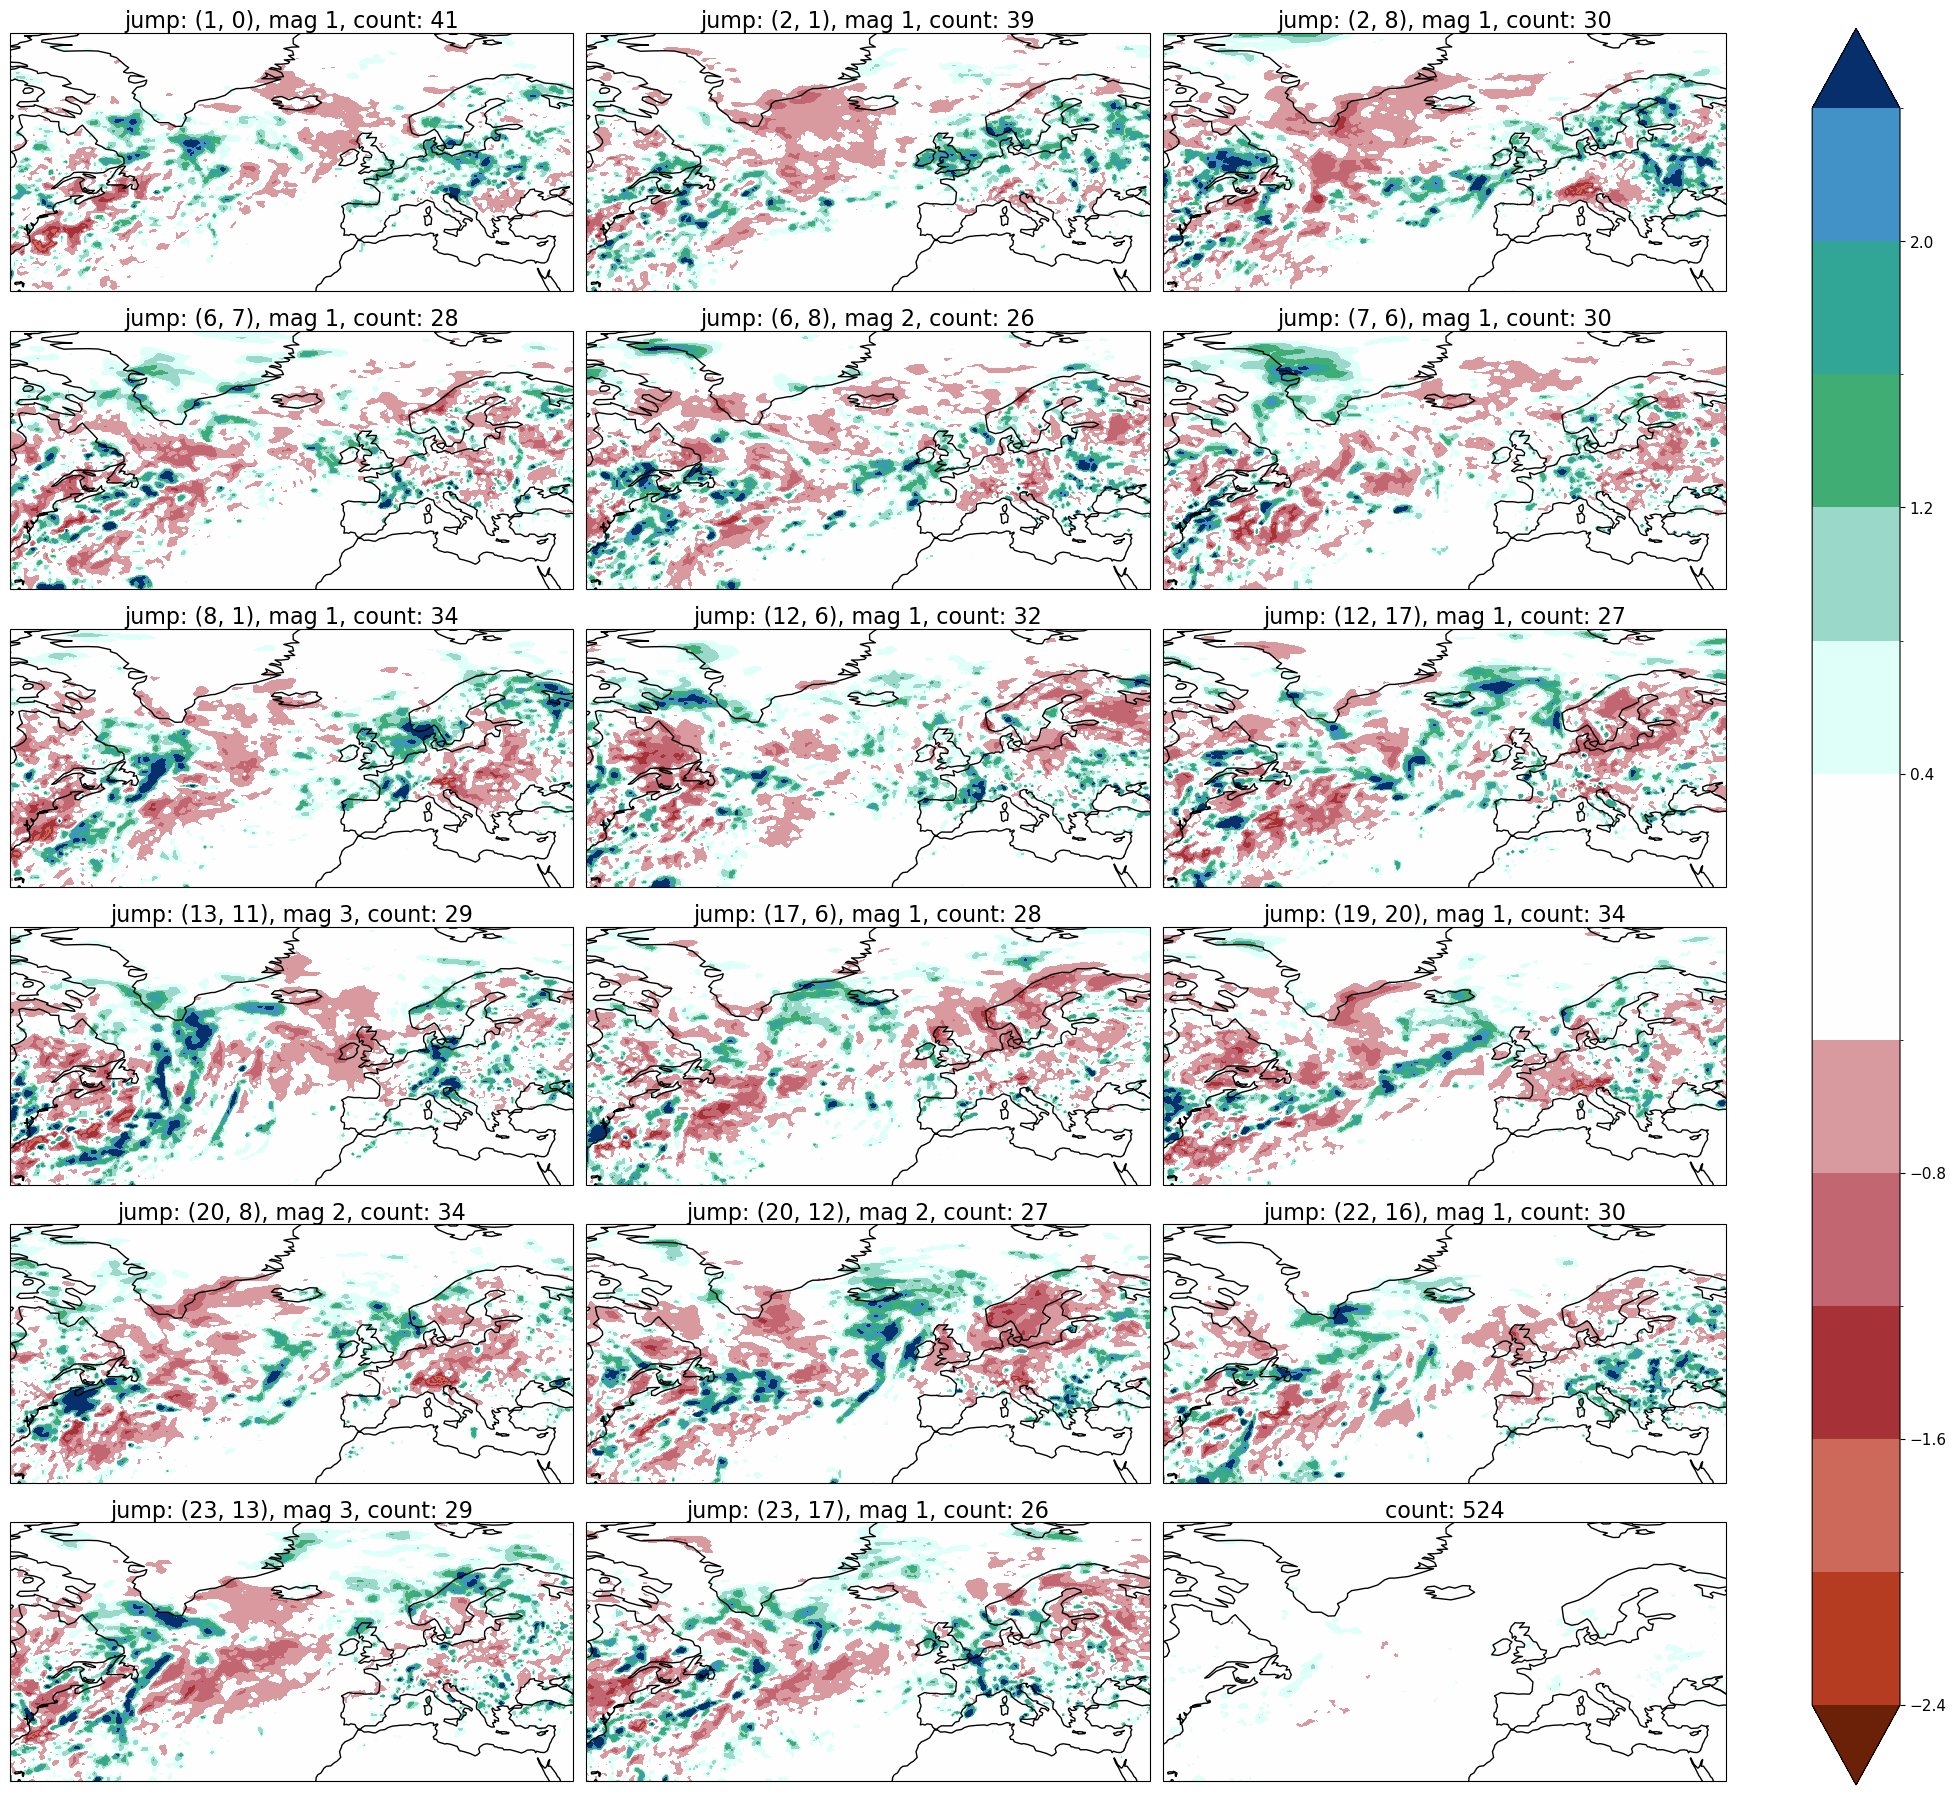

In [109]:
clu = Clusterplot(6, 3, region=get_region(da_))
_ = clu.add_contourf([a * 10000 for a in to_plot], titles=titles, cmap=colormaps.precip4_diff_19lev, levels=15, transparify=0)